<a href="https://colab.research.google.com/github/Daniyal6124/HPP/blob/main/HPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading  the Boston Housing Dataset

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

class LinearRegressionScratch:
    def fit(self, X, y, lr=0.01, epochs=1000):
        self.m, self.n = X.shape
        self.W = np.zeros(self.n)
        self.b = 0
        for _ in range(epochs):
            y_pred = X.dot(self.W) + self.b
            # Check for NaN in y_pred
            if np.isnan(y_pred).any():
                print("Warning: NaN values encountered in y_pred during training.")
                y_pred = np.nan_to_num(y_pred)  # Replace NaN with 0

            error = y_pred - y
            self.W -= lr * (1/self.m) * X.T.dot(error)
            self.b -= lr * (1/self.m) * np.sum(error)

    def predict(self, X):
        y_pred = X.dot(self.W) + self.b
        # Check for NaN in y_pred
        if np.isnan(y_pred).any():
            print("Warning: NaN values encountered in y_pred during prediction.")
            y_pred = np.nan_to_num(y_pred)  # Replace NaN with 0
        return y_pred

df = pd.read_csv("/content/Boston - Boston.csv")
data = df
df = pd.DataFrame(data.values, columns=data.columns)
X = df.drop('price', axis=1)  # Features
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr_model = LinearRegressionScratch()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

Normalizing Numerical Features

In [ ]:
numerical_features = df.columns[df.dtypes != 'object']
df[numerical_features] = (df[numerical_features] - df[numerical_features].mean()) / df[numerical_features].std()


 Model Implementation (Linear Regression)

In [ ]:
import numpy as np

class LinearRegressionScratch:
    def fit(self, X, y, lr=0.01, epochs=1000):
        self.m, self.n = X.shape
        self.W = np.zeros(self.n)
        self.b = 0
        for _ in range(epochs):
            y_pred = X.dot(self.W) + self.b
            error = y_pred - y
            self.W -= lr * (1/self.m) * X.T.dot(error)
            self.b -= lr * (1/self.m) * np.sum(error)

    def predict(self, X):
        return X.dot(self.W) + self.b


 Decision Tree for Random Forest and XGBoost

In [ ]:
class DecisionTreeRegressor:
    def __init__(self, max_depth=5, min_samples_split=10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.feature_importances_ = None

    def fit(self, X, y):
        self.n_features = X.shape[1]
        self.feature_importances_ = np.zeros(self.n_features)
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if depth >= self.max_depth or n_samples < self.min_samples_split:
            return np.mean(y)

        best_feature, best_thresh, best_gain = None, None, -np.inf
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for thresh in thresholds:
                left_idx = X[:, feature] <= thresh
                right_idx = X[:, feature] > thresh
                if len(y[left_idx]) < 1 or len(y[right_idx]) < 1:
                    continue
                gain = self._variance_reduction(y, y[left_idx], y[right_idx])
                if gain > best_gain:
                    best_feature, best_thresh, best_gain = feature, thresh, gain

        if best_gain == -np.inf:
            return np.mean(y)

        self.feature_importances_[best_feature] += best_gain
        left_idx = X[:, best_feature] <= best_thresh
        right_idx = X[:, best_feature] > best_thresh
        left = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._build_tree(X[right_idx], y[right_idx], depth + 1)
        return (best_feature, best_thresh, left, right)

    def _variance_reduction(self, parent, l_child, r_child):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        return np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))

    def predict_sample(self, node, x):
        if not isinstance(node, tuple):
            return node
        feature, thresh, left, right = node
        if x[feature] <= thresh:
            return self.predict_sample(left, x)
        else:
            return self.predict_sample(right, x)

    def predict(self, X):
        return np.array([self.predict_sample(self.tree, x) for x in X])



Random Forest

In [ ]:
class RandomForestScratch:
    def __init__(self, n_estimators=10, max_depth=5):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []
        self.feature_importances_ = None

    def fit(self, X, y):
        self.feature_importances_ = np.zeros(X.shape[1])
        for _ in range(self.n_estimators):
            idxs = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[idxs], y.iloc[idxs]
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
            self.feature_importances_ += tree.feature_importances_
        self.feature_importances_ /= self.n_estimators

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(tree_preds, axis=0)

Evaluation metrics

In [ ]:
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - RMSE: {rmse:.4f}, R2: {r2:.4f}")

Feature Importance Plot

In [ ]:
import matplotlib.pyplot as plt
def plot_feature_importance(importances, feature_names, model_name):
    sorted_idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances[sorted_idx])
    plt.xticks(range(len(importances)), np.array(feature_names)[sorted_idx], rotation=90)
    plt.title(f"{model_name} Feature Importance")
    plt.tight_layout()
    plt.show()

Train and evaluate Linear Regression

In [ ]:
lr_model = LinearRegressionScratch()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
evaluate_model("Linear Regression", y_test, y_pred_lr)

Linear Regression - RMSE: 5.0348, R2: 0.6543


Train and evaluate Random Forest

Random Forest - RMSE: 3.2445, R2: 0.8565


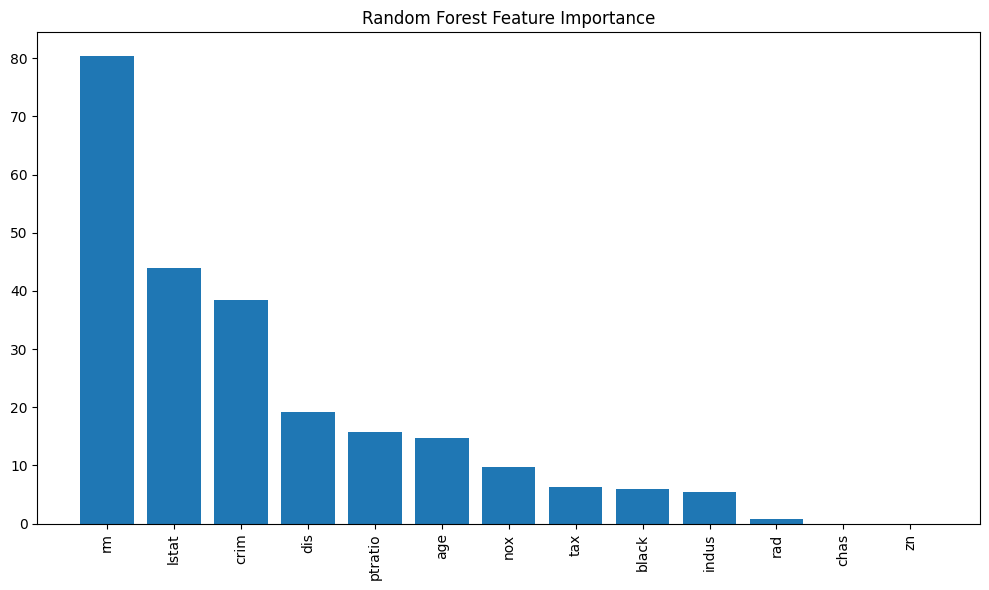

In [ ]:
rf_model = RandomForestScratch(n_estimators=10, max_depth=6)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
evaluate_model("Random Forest", y_test, y_pred_rf)
plot_feature_importance(rf_model.feature_importances_, data.columns, "Random Forest")